# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [2]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


Download the dataset

In [3]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Filter row with length greater than 8.


In [4]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Create a tokenizer and Detokenizer

In [5]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

Remove from corpus the sentences where any unknow word appears

In [6]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [7]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [8]:
from tensorflow.keras.utils import PyDataset

class DataGenerator(PyDataset):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [9]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [10]:
#split the dataset
train_generator = DataGenerator(shuffled_data[:220000])
test_generator = DataGenerator(shuffled_data[220000:])

In [11]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")


original:  <start> ranchers clear large areas of rainforest to become pastures for their cattle <end>
shuffled:  <start> large their areas for cattle ranchers rainforest clear pastures become to of <end>


original:  <start> some earwigs have stripes on the thorax and abdomen <end>
shuffled:  <start> stripes thorax some and the earwigs on abdomen have <end>


original:  <start> magnetic manipulation can turn molecules in a liquid into computing such devices <end>
shuffled:  <start> into in magnetic such a liquid molecules can manipulation computing turn devices <end>


original:  <start> healthy wetlands means cleaner water <comma> reduced flooding and more places for recreation <end>
shuffled:  <start> reduced wetlands and recreation for water places healthy cleaner flooding <comma> means more <end>


original:  <start> market share is the percent share in sales one company controls in a particular market <end>
shuffled:  <start> company percent share one controls a sales in market is

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [12]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [13]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

---

# Import of the modules

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Initializing Data Generators and Calculating Test Batches

To prepare the data for training and testing, I start by creating data generators. For the training data, I use the first 220000 samples from `original_data` and set up a `train_generator` with a batch size of `32`. This means each batch will contain 32 samples, which is a good size for efficient training.

For the test data, I use the remaining samples, starting from sample 220000 to the end, and create a `test_generator`, also with a batch size of 32. This keeps the batch sizes consistent across training and testing.

Next, I need to calculate the number of test batches. I do this by dividing the number of test samples by 32 and rounding up to ensure all samples are included. This calculation gives `TEST_BATCHES`, which tells the total number of batches processed during testing.

In [15]:
train_generator = DataGenerator(original_data[:220000], batch_size=32)
test_generator = DataGenerator(original_data[220000:], batch_size=32)
TEST_BATCHES = round((original_data.shape[0]-220000)/32)

# Creation of the model

For the task of taking a sentence with shuffled words and returning it in the correct order, a Transformer model is a good choice, because transformers can capture long-range dependencies and relationships between words, regardless of their position in the sentence, due to the mechanism of attention. This is crucial for understanding the context and meaning in a sentence where word order is scrambled.


# Transformer Encoder


The Encoder has the following structure.

**Embedding Layers**: Initially, the encoder transforms each word in the input sentence into dense vectors using two embedding layers: `token_embed`, representing the semantic meaning, and `position_embed`, which incorporates positional information into the embeddings, ensuring the model understands the order of words in the sentence.

**Multi-Head Attention Layers**: The encoder employs two layers of multi-head attention mechanisms (`multihead_attention1` and `multihead_attention2`). Following each attention layer, normalization layers (`norm_layer1` and `norm_layer2`) stabilize and optimize the output for efficient training.

**Feed-Forward Network**: After the attention layers, the encoder utilizes a feed-forward network (`feed_forward`) to further process the data. In particular, it has two `Dense` layers and also two `Dropout` layers, to reduce overfitting. The output is then normalized by `norm_layer3` to ensure consistency and stability.

**Call Method**: It applies in sequence the layers described above.


In [16]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_heads_1, num_heads_2, ff_size, embed_size):
        super().__init__()
        self.token_embed = tf.keras.layers.Embedding(input_dim=LEN_VOC, output_dim=embed_size)
        self.position_embed = tf.keras.layers.Embedding(input_dim=embed_size, output_dim=embed_size)

        self.multihead_attention1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads_1, key_dim=embed_size)
        self.norm_layer1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.multihead_attention2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads_2, key_dim=embed_size)
        self.norm_layer2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_size, activation="relu"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(embed_size),
            tf.keras.layers.Dropout(0.1),
        ])
        self.norm_layer3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        sequence_input = inputs
        seq_length = tf.shape(sequence_input)[-1]
        pos_indices = tf.range(start=0, limit=seq_length, delta=1)
        pos_embed = self.position_embed(pos_indices)
        tok_embed = self.token_embed(sequence_input)
        combined_embed = tok_embed + pos_embed

        attn_output1 = self.multihead_attention1(combined_embed, combined_embed)
        norm_output1 = self.norm_layer1(combined_embed + attn_output1)

        attn_output2 = self.multihead_attention2(norm_output1, norm_output1)
        norm_output2 = self.norm_layer2(norm_output1 + attn_output2)

        ffn_output = self.feed_forward(norm_output2, training=training)
        final_output = self.norm_layer3(norm_output2 + ffn_output)

        return final_output

# Decoder


The Decoder has the following structure.

**Embedding Layers**: The Decoder starts by embedding each word in the input sequence into dense vectors using two embedding layers (the same as the Encoder).

**Masked Multi-Head Attention Layer**: The Decoder utilizes a masked multi-head attention mechanism named `masked_attention` to prevent attending to future tokens during training. This layer helps the model generate each word in the output sequence by considering only the previously generated tokens.

**Multi-Head Attention Layers**: The Decoder employs two layers of multi-head attention mechanisms (`multihead_attention1` and `multihead_attention2`). Each multi-head attention layer is followed by a normalization layer (`norm_layer1`, `norm_layer2`, and `norm_layer3`) to stabilize and optimize the output.

**Feed-Forward Network**: After the attention layers, the Decoder applies a feed-forward network (`feed_forward`) to further process the data. Like the Encoder, it also uses the dropout strategy. The output is then normalized by `norm_layer4` to ensure consistency and stability.

**Call Method**: It applies in sequence the layers described above.


In [17]:
class Decoder(tf.keras.layers.Layer):
        def __init__(self, num_heads_1, num_heads_2, ff_size, embed_size):
            super().__init__()
            self.token_embed = tf.keras.layers.Embedding(input_dim=LEN_VOC, output_dim=embed_size)
            self.position_embed = tf.keras.layers.Embedding(input_dim=embed_size, output_dim=embed_size)

            self.masked_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads_1, key_dim=embed_size)
            self.norm_layer1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

            self.multihead_attention1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads_1, key_dim=embed_size)
            self.norm_layer2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

            self.multihead_attention2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads_2, key_dim=embed_size)
            self.norm_layer3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

            self.feed_forward = tf.keras.Sequential([
                tf.keras.layers.Dense(ff_size, activation="relu"),
                tf.keras.layers.Dropout(0.1),
                tf.keras.layers.Dense(embed_size),
                tf.keras.layers.Dropout(0.1),
            ])
            self.norm_layer4 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        def call(self, inputs, encoder_output, training=False):
            sequence_input = inputs
            seq_length = tf.shape(sequence_input)[-1]
            pos_indices = tf.range(start=0, limit=seq_length, delta=1)
            pos_embed = self.position_embed(pos_indices)
            tok_embed = self.token_embed(sequence_input)
            combined_embed = tok_embed + pos_embed

            masked_attn_output = self.masked_attention(combined_embed, combined_embed, use_causal_mask=True)
            norm_output1 = self.norm_layer1(combined_embed + masked_attn_output)

            attn_output1 = self.multihead_attention1(norm_output1, encoder_output)
            norm_output2 = self.norm_layer2(norm_output1 + attn_output1)

            attn_output2 = self.multihead_attention2(norm_output2, encoder_output)
            norm_output3 = self.norm_layer3(norm_output2 + attn_output2)

            ffn_output = self.feed_forward(norm_output3, training=training)
            final_output = self.norm_layer4(norm_output3 + ffn_output)

            return final_output

# Transformer

The Transformer is made of the `Encoder`, the `Decoder` and the output layer, which uses the `softmax` activation function. This is because I want to convert the raw output scores into a probability distribution over the output vocabulary. Each element of the distribution represents the likelihood of a particular token being the next word in the sequence.

In [18]:
class Transformer(tf.keras.layers.Layer):
    def __init__(self, num_heads_1, num_heads_2, ff_size, embed_size):
        super().__init__()
        self.encoder = Encoder(num_heads_1, num_heads_2, ff_size, embed_size)
        self.decoder = Decoder(num_heads_1, num_heads_2, ff_size, embed_size)
        self.final_dense = tf.keras.layers.Dense(LEN_VOC, activation='softmax')

    def call(self, inputs, training=False):
        encoder_output = self.encoder(inputs, training=training)
        decoder_output = self.decoder(inputs, encoder_output, training=training)
        final_output = self.final_dense(decoder_output)
        return final_output

# Function for creation of the model

Now that I have the structure of the model, I create a function that builds a transformer by passing the hyperparameters. This is a handful way to prove different parametrization of the model, in order to get the best one.

In [19]:
def create_model(num_heads_1, num_heads_2, ff_size, embed_size, optimizer):
    class Encoder(tf.keras.layers.Layer):
        def __init__(self, num_heads_1, num_heads_2, ff_size, embed_size):
            super().__init__()
            self.token_embed = tf.keras.layers.Embedding(input_dim=LEN_VOC, output_dim=embed_size)
            self.position_embed = tf.keras.layers.Embedding(input_dim=embed_size, output_dim=embed_size)

            self.multihead_attention1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads_1, key_dim=embed_size)
            self.norm_layer1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

            self.multihead_attention2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads_2, key_dim=embed_size)
            self.norm_layer2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

            self.feed_forward = tf.keras.Sequential([
                tf.keras.layers.Dense(ff_size, activation="relu"),
                tf.keras.layers.Dropout(0.1),
                tf.keras.layers.Dense(embed_size),
                tf.keras.layers.Dropout(0.1),
            ])
            self.norm_layer3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        def call(self, inputs, training=False):
            sequence_input = inputs
            seq_length = tf.shape(sequence_input)[-1]
            pos_indices = tf.range(start=0, limit=seq_length, delta=1)
            pos_embed = self.position_embed(pos_indices)
            tok_embed = self.token_embed(sequence_input)
            combined_embed = tok_embed + pos_embed

            attn_output1 = self.multihead_attention1(combined_embed, combined_embed)
            norm_output1 = self.norm_layer1(combined_embed + attn_output1)

            attn_output2 = self.multihead_attention2(norm_output1, norm_output1)
            norm_output2 = self.norm_layer2(norm_output1 + attn_output2)

            ffn_output = self.feed_forward(norm_output2, training=training)
            final_output = self.norm_layer3(norm_output2 + ffn_output)

            return final_output

    class Decoder(tf.keras.layers.Layer):
        def __init__(self, num_heads_1, num_heads_2, ff_size, embed_size):
            super().__init__()
            self.token_embed = tf.keras.layers.Embedding(input_dim=LEN_VOC, output_dim=embed_size)
            self.position_embed = tf.keras.layers.Embedding(input_dim=embed_size, output_dim=embed_size)

            self.masked_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads_1, key_dim=embed_size)
            self.norm_layer1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

            self.multihead_attention1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads_1, key_dim=embed_size)
            self.norm_layer2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

            self.multihead_attention2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads_2, key_dim=embed_size)
            self.norm_layer3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

            self.feed_forward = tf.keras.Sequential([
                tf.keras.layers.Dense(ff_size, activation="relu"),
                tf.keras.layers.Dropout(0.1),
                tf.keras.layers.Dense(embed_size),
                tf.keras.layers.Dropout(0.1),
            ])
            self.norm_layer4 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        def call(self, inputs, encoder_output, training=False):
            sequence_input = inputs
            seq_length = tf.shape(sequence_input)[-1]
            pos_indices = tf.range(start=0, limit=seq_length, delta=1)
            pos_embed = self.position_embed(pos_indices)
            tok_embed = self.token_embed(sequence_input)
            combined_embed = tok_embed + pos_embed

            masked_attn_output = self.masked_attention(combined_embed, combined_embed, use_causal_mask=True)
            norm_output1 = self.norm_layer1(combined_embed + masked_attn_output)

            attn_output1 = self.multihead_attention1(norm_output1, encoder_output)
            norm_output2 = self.norm_layer2(norm_output1 + attn_output1)

            attn_output2 = self.multihead_attention2(norm_output2, encoder_output)
            norm_output3 = self.norm_layer3(norm_output2 + attn_output2)

            ffn_output = self.feed_forward(norm_output3, training=training)
            final_output = self.norm_layer4(norm_output3 + ffn_output)

            return final_output

    class Transformer(tf.keras.layers.Layer):
        def __init__(self, num_heads_1, num_heads_2, ff_size, embed_size):
            super().__init__()
            self.encoder = Encoder(num_heads_1, num_heads_2, ff_size, embed_size)
            self.decoder = Decoder(num_heads_1, num_heads_2, ff_size, embed_size)
            self.final_dense = tf.keras.layers.Dense(LEN_VOC, activation='softmax')

        def call(self, inputs, training=False):
            encoder_output = self.encoder(inputs, training=training)
            decoder_output = self.decoder(inputs, encoder_output, training=training)
            final_output = self.final_dense(decoder_output)
            return final_output

    input_layer = tf.keras.layers.Input(shape=(MAX_LEN,))
    transformer_output = Transformer(num_heads_1, num_heads_2, ff_size, embed_size)(input_layer)
    model = tf.keras.Model(inputs=input_layer, outputs=transformer_output)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model


# Inizialization of the model

For the inizialization of the model, I need some parameters and hyperparameters. In particular:

- **LEN_VOC**: The vocabulary size, which is set to `10,000`.
- **MAX_LEN**: The maximum length of input sequences, set to `28`.
- **EMBED_SIZE**: The dimensionality of the token embeddings, set to `64` (a common practice in NLP tasks). This determines the size of the dense vector representation for each word.
- **NUM_HEADS_1**: The number of heads in the first multi-head attention layer, set to `16`. This controls the number of parallel attention mechanisms in the layer.
- **NUM_HEADS_2**: The number of heads in the second multi-head attention layer, set to `16`.
- **FF_SIZE**: The size of the feed-forward network hidden layer, set to `4096`.
- **OPTIMIZER**: The optimizer used for training the model, which is `AdamW`. It handles weight decay more efficiently, and improves generalization.
- **EPOCHS**: The number of epochs for training the model, set to `30`.

These constants define key parameters and settings used in the model architecture and training process.
Empirically, it's proven that a high number of attention heads leads often to better performances, but this can cause an increase of the total number of parameters.

In [20]:
LEN_VOC = 10000
MAX_LEN = 28
EMBED_SIZE = 64
NUM_HEADS_1 = 16
NUM_HEADS_2 = 16
FF_SIZE = 4096
OPTIMIZER = tf.keras.optimizers.AdamW()
EPOCHS = 30

Now I can proceed to the creation and compilation of the model (which happens inside the function). I use `sparse_categorical_crossentropy` as loss function because it is suitable for classification tasks with multiple classes, where each input can belong to only one class, and in this task each word can be considered as a class, while the target labels are integers representing the indices of words in the correct order.

In [21]:
# Create and compile the model
transformer = create_model(NUM_HEADS_1, NUM_HEADS_2, FF_SIZE, EMBED_SIZE, OPTIMIZER)

# Training

I can now start the train of the model, using thirthy epochs (which should lead to convergence), and `batch_size = 32` to get more regularization and more memory efficiency.

In [22]:
results = transformer.fit(train_generator, batch_size=32, epochs=EPOCHS)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6875/6875 ━━━━━━━━━━━━━━━━━━━━ 139s 17ms/step - accuracy: 0.6401 - loss: 2.4791
Epoch 2/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 118s 17ms/step - accuracy: 0.7106 - loss: 1.1758
Epoch 3/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 117s 17ms/step - accuracy: 0.7251 - loss: 1.0399
Epoch 4/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 144s 17ms/step - accuracy: 0.7350 - loss: 0.9738
Epoch 5/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 119s 17ms/step - accuracy: 0.7433 - loss: 0.9290
Epoch 6/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - accuracy: 0.7495 - loss: 0.8960
Epoch 7/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 117s 17ms/step - accuracy: 0.7549 - loss: 0.8695
Epoch 8/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 117s 17ms/step - accuracy: 0.7600 - loss: 0.8462
Epoch 9/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - accuracy: 0.7643 - loss: 0.8260
Epoch 10/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 119s 17ms/step - accuracy: 0.7682 - loss: 0.8099
Epoch 11/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 119s 17ms/step - accuracy: 0.7715 - loss: 0.7950
Epoch 12

The following plot represents the history of the training.

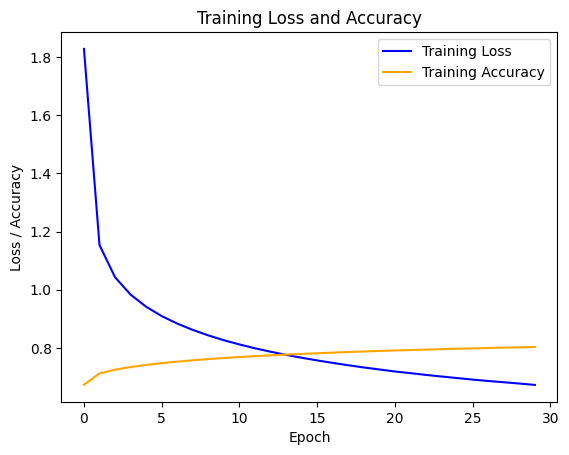

In [24]:
history = results.history
plt.plot(history['loss'], label='Training Loss', color='blue')
plt.plot(history['accuracy'], label='Training Accuracy', color='orange')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

It's clearly visible that the loss decreases rapidly during the first 5 epochs, and it becomes lower and lower until we get to the 30th epoch, as well as the accuracy, which increases steadly.

# Testing

The following cell contains a test function that evaluates the performances of the model by computing the average score over all the test set.

In [25]:
def evaluate_model(num_test_batches, test_gen, model, detokenizer, score):
    total_score_pred = 0

    for batch_idx in range(num_test_batches):
        inputs, targets = test_gen.__getitem__(batch_idx)
        preds = model.predict(inputs, batch_size=1)
        best_predictions = []

        for pred_idx in range(len(preds)):
            best_inner = []
            for seq_idx in range(len(preds[pred_idx])):
                best_inner.append(np.argmax(preds[pred_idx][seq_idx]))
            best_predictions.append(best_inner)

        for sample_idx in range(len(inputs)):
            total_score_pred += score(detokenizer(targets)[sample_idx], detokenizer(best_predictions)[sample_idx])

    avg_score_pred = total_score_pred / (len(inputs) * num_test_batches)

    return avg_score_pred


In [26]:
%%capture
avg_score_pred = evaluate_model(TEST_BATCHES, test_generator, transformer, detokenizer, score)

In [27]:
print(f"The average score on the test set is: {avg_score_pred}")

The average score on the test set is: 0.39277304500705584


The average score on the test set is 0.39, which is around three std higher than the baseline mean, as requested.

# Summary of the model

Let's look at the specifics of the model.

*NOTE*: the output of the `summary()` method may not be visible if you open the file with some IDEs (like VSCode). It's suggested to use Colab or Kaggle instead.

In [28]:
transformer.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer (Transformer)            │ (None, 28, 10000)           │       4,322,384 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,967,154 (49.47 MB)

 Trainable params: 4,322,384 (16.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,644,770 (32.98 MB)

The model has less than 20M parameters, and in particular it has just 4M trainable parameters. The majority of them comes from the optimizer, which uses the double of the trainable parameters.

# Failed alternative models

*NOTE*: the following models are some failed attempts I did. The final model is just the one built in the previous section of the notebook.

In order to reach higher performances, I can make `EMBED_SIZE` bigger, but I should also take into account the total number of parameters, which should not be above the given threshold. Let's try by using `128`, but with just `2` for the heads.

In [31]:
%%capture

LEN_VOC = 10000
MAX_LEN = 28
EMBED_SIZE = 128
NUM_HEADS_1 = 2
NUM_HEADS_2 = 2
FF_SIZE = 4096
OPTIMIZER = tf.keras.optimizers.AdamW()
EPOCHS = 1

transformer = create_model(NUM_HEADS_1, NUM_HEADS_2, FF_SIZE, EMBED_SIZE, OPTIMIZER)
results = transformer.fit(train_generator, batch_size=32, epochs=EPOCHS)

In [32]:
transformer.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_2 (Transformer)          │ (None, 28, 10000)           │       6,650,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,950,002 (76.10 MB)

 Trainable params: 6,650,000 (25.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,300,002 (50.74 MB)

It's clear that the number of parameters decreases and stays below 20M, but since I put `2` as number of heads, this model has few attention, meaning that it leads to very bad results. Let's try to increase the number of heads.

In [29]:
%%capture

LEN_VOC = 10000
MAX_LEN = 28
EMBED_SIZE = 128
NUM_HEADS_1 = 16
NUM_HEADS_2 = 12
FF_SIZE = 4096
OPTIMIZER = tf.keras.optimizers.AdamW()
EPOCHS = 1

transformer = create_model(NUM_HEADS_1, NUM_HEADS_2, FF_SIZE, EMBED_SIZE, OPTIMIZER)
results = transformer.fit(train_generator, batch_size=32, epochs=EPOCHS)

In [30]:
transformer.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_1 (Transformer)          │ (None, 28, 10000)           │      10,737,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,211,122 (122.88 MB)

 Trainable params: 10,737,040 (40.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,474,082 (81.92 MB)

This model has way more parameters than the given threshold, meaning that it's not suitable.

# Conclusions

In conclusion:

- Using a transformer model for the sentence reordering task leads to overall good results.
  
- The selection of the right hyperparameters is essential for the performance of the model, and also to keep low the number of parameters.

- I opted to use the AdamW optimizer due to its effectiveness in handling weight decay regularization, stability with sparse gradients, and empirical performance in deep learning tasks.

- For the classification task with sparse integer labels representing word indices, I chose sparse categorical crossentropy as the loss function. This choice simplifies implementation, handles multiple classes efficiently, and facilitates effective training and optimization.

- There is a trade-off between the total number of parameters and the performance of the model. If I want to keep few parameters, my model will not have amazing results (and the task explicitly requested less than 20M of them). After all, given an average score of 0.39, the results are good enough to define the model as effective and efficient.